In [ ]:
# @ Annu Zhou azhou60@gatech.edu

#### Please install necessary packages first ...

In [1]:
!pip install wordcloud
!pip install nltk
!pip install sklearn
# !pip install json
!pip install tqdm
!pip install matplotlib

#### Import ...

In [3]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


 
import re
import json
import os
from collections import Counter
import datetime as dt


 
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


 
import pickle

In [4]:
import sys
print(sys.executable)

C:\anaconda3\envs\gnn_inter\python.exe


## 1 Read Data  


In [6]:
data_dir = '../data/kaggle-covid-tweets-april'
tweets = []
n=8
n0=4
## read the first n-n0+1 days tweets in the dataset, e.g., from Apr.2nd to Apr. 9th
for file in sorted(os.listdir(data_dir))[n0:n-1]:
    tweets.append(pd.read_csv(data_dir + '/' + file, lineterminator = '\n'))
df = pd.concat(tweets)
## print several examples pf the data points
df.tail()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,followers_count,friends_count,account_lang,account_created_at,verified,lang,Hate Probability,Counterhate Probability,Neutral Probability,Label
617818,1246588353501429761,109538525,2020-04-04T23:59:58Z,ioanauoft,Some days I still hope these people will be he...,Twitter for iPhone,NaN,NaN,NaN,True,...,282,246,NaN,2010-01-29T11:43:59Z,False,en,0.027740,0.095271,0.536761,Neutral
617819,1246588355921379328,912282321105051649,2020-04-04T23:59:59Z,cynica1idealist,Another empty speech from the leech who has be...,Twitter Web App,NaN,NaN,NaN,True,...,774,205,NaN,2017-09-25T11:47:09Z,False,en,0.013534,0.024222,0.724363,Neutral
617820,1246588356068286464,61206610,2020-04-04T23:59:59Z,npquarterly,40 US and international foundations have signe...,HubSpot,NaN,NaN,NaN,False,...,128044,3044,NaN,2009-07-29T14:27:16Z,False,en,0.000387,0.007434,0.990744,Neutral
617821,1246588358064627712,469330483,2020-04-04T23:59:59Z,JustineWaldman,On @kron4news at 5pm: When it comes to the #co...,Twitter Web App,NaN,NaN,NaN,False,...,3776,1366,NaN,2012-01-20T13:48:17Z,True,en,0.010430,0.020267,0.980666,Neutral
617822,1246588358333272066,3186926132,2020-04-04T23:59:59Z,TFaseruk,.@BMO @RBC I'm asking you to lower credit card...,Twitter for iPhone,NaN,NaN,NaN,False,...,3,1,NaN,2015-05-06T17:54:06Z,False,en,0.001110,0.238429,0.923629,Neutral


## 2 Tweet Frequency in a Specifc Time Period

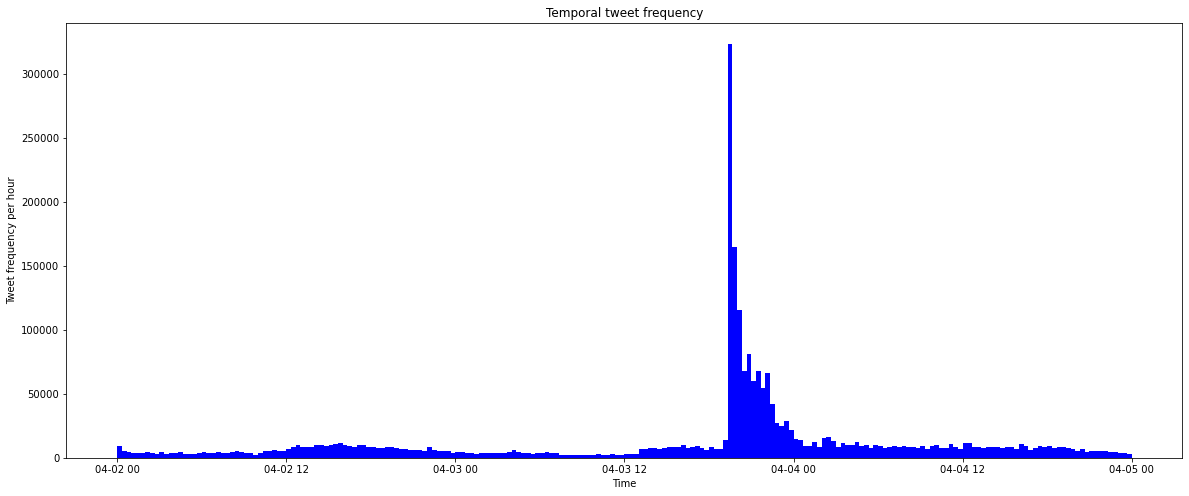

In [7]:
## Plot the tweet frequency from a specific time period. 
## You could speficify this the time length by yourself
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df.created_at), bins = 24*9, color = 'b')
plt.show()

## 3 Preprocessing
Now we need to do the following steps to initialize the tweets
+ Removing URLs from tweets
+ Converting all tweets to lowercase
+ Removing punctuations
+ Removing stopwords

### 3.1 Removing URLs from tweets

In [8]:
text_en = df['text']
# text_en = df['Text']
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

0    Global stocks suffer another rout as coronavir...
1    Global stocks suffer another rout as coronavir...
2    A #Kamloops paramedic is hoping to organize a ...
3    WATCH: Man uses drone to send sister toilet pa...
4    Aaron Lutes speaks explains how the Gilda's Cl...
Name: text, dtype: object

### 3.2 Converting all tweets to lowercase

In [9]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    global stocks suffer another rout as coronavir...
1    global stocks suffer another rout as coronavir...
2    a #kamloops paramedic is hoping to organize a ...
3    watch: man uses drone to send sister toilet pa...
4    aaron lutes speaks explains how the gilda's cl...
Name: text, dtype: object

### 3.3 Removing punctuations

In [10]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    global stocks suffer another rout as coronavir...
1    global stocks suffer another rout as coronavir...
2    a kamloops paramedic is hoping to organize a d...
3    watch man uses drone to send sister toilet pap...
4    aaron lutes speaks explains how the gildas clu...
Name: text, dtype: object

### 3.4 Removing stopwords
Herein, we also need to add the words such as "coronavirus" as the stopwords. This is similar to what we have done in HW3.

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0     global stocks suffer another rout crisis deepens
1     global stocks suffer another rout crisis deepens
2    kamloops paramedic hoping organize daily rally...
3    watch man uses drone send sister toilet paper ...
4    aaron lutes speaks explains gildas club simcoe...
Name: text, dtype: object

In [12]:
### Show the top-m frequent words in our corpus
m = 51
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:m-1]

['global',
 'stocks',
 'suffer',
 'another',
 'rout',
 'crisis',
 'deepens',
 'global',
 'stocks',
 'suffer',
 'another',
 'rout',
 'crisis',
 'deepens',
 'kamloops',
 'paramedic',
 'hoping',
 'organize',
 'daily',
 'rally',
 'salute',
 'hospital',
 'staff',
 'fighting',
 'royal',
 'inland',
 'hospital',
 'watch',
 'man',
 'uses',
 'drone',
 'send',
 'sister',
 'toilet',
 'paper',
 'amid',
 'virus',
 'lockdown',
 'toiletpaper',
 'drone',
 'unitedkingdom',
 'covid2019',
 'coronavirusoutbreak',
 'covid',
 'covidー19',
 'coronaviruspandemic',
 'aaron',
 'lutes',
 'speaks',
 'explains']

## 4 Histgrams - Frequency
Plot the word frequency.

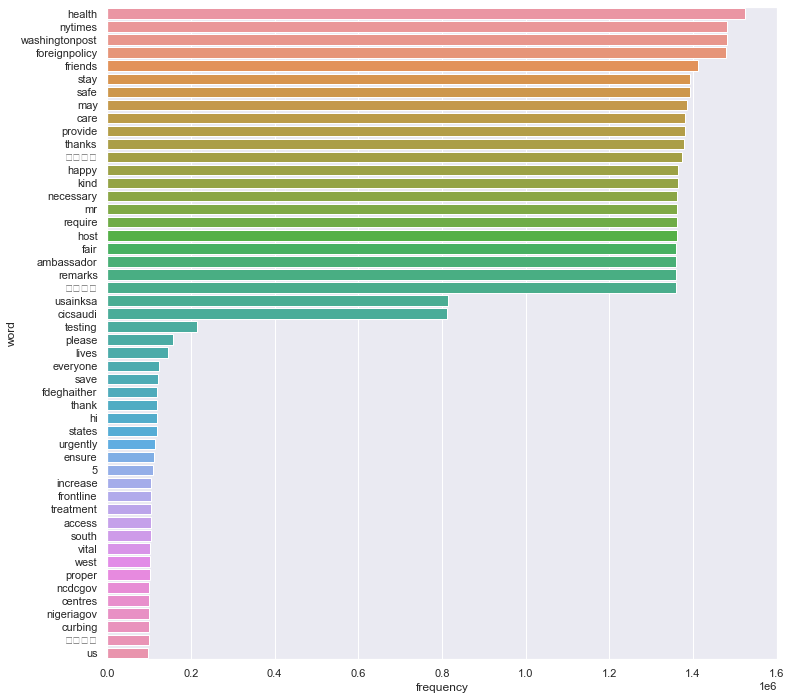

In [13]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')
plt.show()

## 5 Sentiment Analysis
We will do some simple sentiment analysis here. 

In [14]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

,neg,neu,pos,compound
2484269,0.154,0.553,0.293,0.3626
2484270,0.079,0.921,0.000,-0.2023
2484271,0.000,1.000,0.000,0.0000
2484272,0.140,0.860,0.000,-0.0772
2484273,0.200,0.571,0.229,0.1779


In [15]:
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,neg,neu,pos,compound,val
0,0.603,0.397,0.000,-0.8225,negative
1,0.603,0.397,0.000,-0.8225,negative
2,0.153,0.675,0.172,0.0772,positive
3,0.000,1.000,0.000,0.0000,neutral
4,0.000,0.803,0.197,0.4019,positive


### Sentiment Analysis Plot

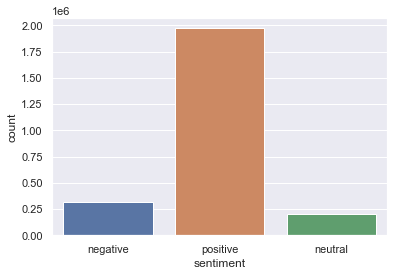

In [16]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')
plt.show()

## 6 Wordcloud Visulization
Now, we visualize wordcloud to see the performance.

### 6.1 Wordcloud Plot for the Whole Dataset

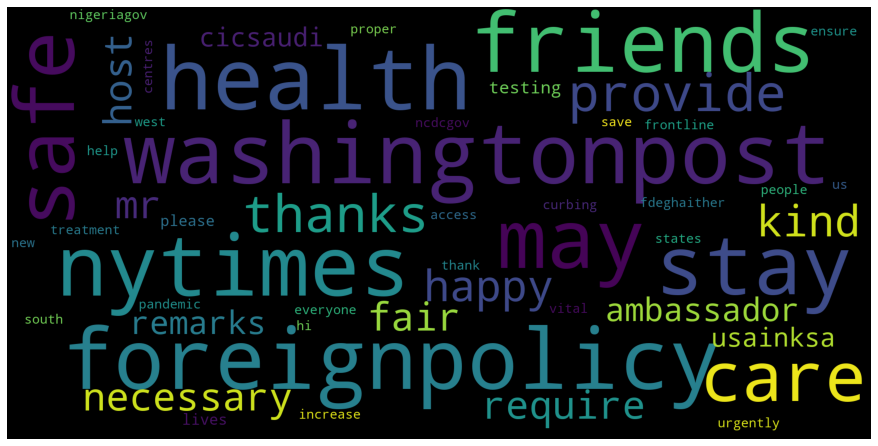

In [17]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')
plt.show()

### 6.2 Comprehensive Wordcloud Plot

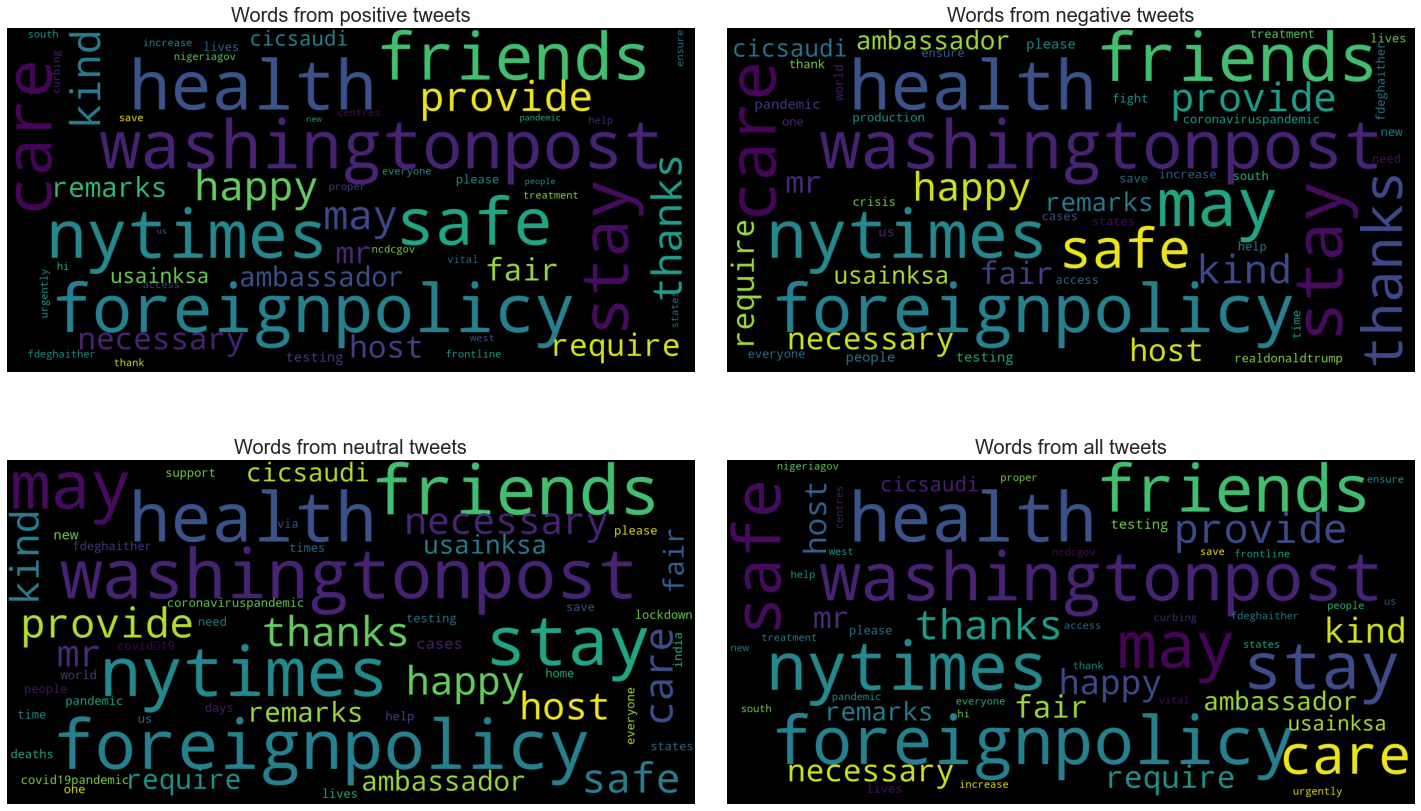

In [18]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))

fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')


axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')


axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')


axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')

plt.savefig('joint_cloud.png')

## 7 Term Frequency–inverse Document Frequency (TF-IDF)

In [5]:
def process_tweet(tweet):
    """
        Preprocess tweet. Remove URLs, leading user handles, retweet indicators, emojis,
        and unnecessary white space, and remove the pound sign from hashtags. Return preprocessed
        tweet in lowercase.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """

    # Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))\s+', '', tweet)
    tweet = re.sub('\s+((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)
    # Remove RTs
    tweet = re.sub('^RT @[A-Za-z0-9_]+: ', '', tweet)
    # Incorrect apostraphe
    tweet = re.sub(r"’", "'", tweet)
    # Remove @username
    tweet = remove_leading_usernames(tweet)
    # Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Replace ampersands
    tweet = re.sub(r' &amp; ', ' and ', tweet)
    tweet = re.sub(r'&amp;', '&', tweet)
    # Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # trim
    tweet = tweet.strip('\'"')
    return tweet.lower().strip()

In [6]:
def remove_leading_usernames(tweet):
    """
        Remove all user handles at the beginning of the tweet.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    regex_str = '^[\s.]*@[A-Za-z0-9_]+\s+'

    original = tweet
    change = re.sub(regex_str, '', original)

    while original != change:
        original = change
        change = re.sub(regex_str, '', original)

    return change

In [7]:

def read_annotations(in_fn):
    df = pd.read_csv(in_fn, dtype=str)
    df_dict = df.to_dict('series')
    # word tokenize each tweet
    for i in range(len(df_dict['Text'])):
        df_dict['Text'][i] = process_tweet(df_dict['Text'][i])
        df_dict['Text'][i] = remove_leading_usernames(df_dict['Text'][i])
        df_dict['Text'][i] = list(word_tokenize(df_dict['Text'][i]))
    # each element in df_text is a list of words in this tweet
    # df_text = df_dict['Text']
    return df_dict

def read_annotations_test(in_fn):
    df = pd.read_csv(in_fn, dtype=str)
    df_dict = df.to_dict('series')
    # word tokenize each tweet
    for i in range(len(df_dict['text'])):
        df_dict['text'][i] = process_tweet(df_dict['text'][i])
        df_dict['text'][i] = remove_leading_usernames(df_dict['text'][i])
        df_dict['text'][i] = list(word_tokenize(df_dict['text'][i]))
    # each element in df_text is a list of words in this tweet
    # df_text = df_dict['Text']
    return df_dict

In [8]:
# tf_idf; return the words with the top k tf_idf
def tf_idf_K(df_dict, k):
    # df_text = df_dict['Text']
    all_words = []
    for i in range(len(df_dict['Text'])):
        all_words.extend(df_dict['Text'][i])
#     print(all_words)
#     print(len(all_words))
    all_words = nltk.FreqDist(all_words)
    topk = all_words.most_common(k)
    print("The top %d important words" % k)
    print(topk)

    return topk, all_words


def tf_idf_K_test(df_dict, k):
    # df_text = df_dict['Text']
    all_words = []
    for i in range(len(df_dict['text'])):
        all_words.extend(df_dict['text'][i])
#     print(all_words)
#     print(len(all_words))
    all_words = nltk.FreqDist(all_words)
    topk = all_words.most_common(k)
    print("The top %d important words" % k)
    print(topk)

    return topk, all_words

In [9]:
def find_features(document, all_words, k):
    words = set(document)
    features = {}
    word_features = list(all_words.keys())[:k]
    for w in word_features:
        features[w] = (w in words)
    return features

In [10]:
if __name__ == '__main__':

    in_fn = "../data/claws_annotations.csv"
    ### for CLAWs Dateset: annotations.csv
    df_dict = read_annotations(in_fn)
    ## you can specify k by youself
    k = 100
    topk, all_words = tf_idf_K(df_dict, k)
    feature_sets = []
    for i in range(len(df_dict['Text'])):
        feature_vec = find_features(df_dict['Text'][i], all_words, k)
        feature_label = df_dict['Label'][i]
        feature_sets.append((feature_vec,feature_label))
    train_set, test_set = feature_sets[100:len(df_dict['Text'])-1], feature_sets[:100]
    
#     # for the test dataset
#     in_fn = "data/2020-04-14 Coronavirus Tweets.csv"
#     df_dict = read_annotations_test(in_fn)
#     ## you can specify k by youself
#     k = 100
#     topk, all_words = tf_idf_K_test(df_dict, k)
#     feature_sets = []
#     for i in range(len(df_dict['text'])):
#         feature_vec = find_features(df_dict['text'][i], all_words, k)
#         feature_label = df_dict['Label'][i]
#         feature_sets.append((feature_vec,feature_label))

#     train_set, test_set = feature_sets[100:len(df_dict['Text'])-1], feature_sets[:100]

The top 100 important words
[('the', 2647), ('.', 2621), (',', 1564), ('to', 1438), ('and', 1314), ('a', 1042), ('is', 973), ('of', 963), ('!', 902), ('coronavirus', 860), ('you', 831), ('in', 799), ('chinese', 764), ('virus', 747), ('it', 715), ('china', 667), ('this', 614), ('i', 592), ('?', 556), ('are', 514), ("'s", 512), ('that', 507), ('for', 496), ('@', 495), ('people', 437), ("n't", 387), ('not', 370), ('on', 366), ('we', 361), ('they', 359), ('racist', 333), ('with', 331), ('from', 321), ('have', 313), ('shit', 312), (':', 305), ('all', 293), ('fuck', 290), ('do', 289), ('be', 284), ('your', 246), ('as', 243), ('fucking', 236), ('about', 228), ('covid19', 228), ('us', 214), ('who', 214), ('asian', 213), ('wuhan', 213), ('if', 210), ('has', 209), ('but', 206), ('their', 205), ('world', 204), ('like', 204), ('...', 200), ('was', 199), ('now', 195), ('just', 191), ('what', 190), ('so', 189), ('no', 177), ('racismisavirus', 177), ('will', 176), ('by', 176), ("''", 172), ('because'